In [11]:
import funzioni as fx
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Bidirectional, BatchNormalization, LSTM, Dropout, Dense, Conv1D, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
import tensorflow_addons as tfa

tot_ticker = 1000
bilanciamento = 0.25
batch_size = 2052
soglia = 0.5
class_weights = {0: 0.5, 1: 1}

X = np.load(f'dati/X_{tot_ticker}_{bilanciamento}.npy')
Y = np.load(f'dati/Y_{tot_ticker}_{bilanciamento}.npy')

print("Versione TensorFlow:", tf.__version__)
print("Versione CUDA:", tf.sysconfig.get_build_info()['cuda_version'])
print("Versione cuDNN:", tf.sysconfig.get_build_info()['cudnn_version'])
import psutil

def print_memory_usage():
    print(f"Memory usage: {psutil.virtual_memory().percent}%")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpu, 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("nessuna GPU")

Versione TensorFlow: 2.9.2
Versione CUDA: 11.2
Versione cuDNN: 8
1 Physical GPUs, 1 Logical GPUs


In [12]:
def crea_modello():
    model = Sequential()
    
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(fx.n_timesteps, fx.n_features)))
    model.add(BatchNormalization())  
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.5)) 
    model.add(LSTM(50))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    
    model.add(Dense(1, activation='sigmoid'))    
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=1, average='macro', threshold=soglia)])
    
    return model

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
callbacks = [reduce_lr, model_checkpoint]

model = crea_modello()  
history = model.fit(X, Y, epochs=100, batch_size=batch_size, validation_split=0.2, callbacks=callbacks, class_weight=class_weights)

2023-11-03 13:46:56.934855: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 806023200 exceeds 10% of free system memory.
2023-11-03 13:46:57.829274: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 806023200 exceeds 10% of free system memory.


Epoch 1/100
164/164 [==============================] - ETA: 0s - loss: 0.5543 - f1_score: 0.3342
Epoch 1: val_loss improved from inf to 0.38240, saving model to best_model.h5
164/164 [==============================] - 32s 166ms/step - loss: 0.5543 - f1_score: 0.3342 - val_loss: 0.3824 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/100
164/164 [==============================] - ETA: 0s - loss: 0.1666 - f1_score: 0.5361
Epoch 2: val_loss improved from 0.38240 to 0.27642, saving model to best_model.h5
164/164 [==============================] - 26s 156ms/step - loss: 0.1666 - f1_score: 0.5361 - val_loss: 0.2764 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/100
164/164 [==============================] - ETA: 0s - loss: 0.1299 - f1_score: 0.5664
Epoch 3: val_loss improved from 0.27642 to 0.20709, saving model to best_model.h5
164/164 [==============================] - 26s 156ms/step - loss: 0.1299 - f1_score: 0.5664 - val_loss: 0.2071 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/100
16

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 118, 64)           1024      
                                                                 
 batch_normalization (BatchN  (None, 118, 64)          256       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 118, 50)           23000     
                                                                 
 dropout (Dropout)           (None, 118, 50)           0         
                                                                 
 flatten (Flatten)           (None, 5900)              0         
                                                                 
 dense (Dense)               (None, 50)                295050    
                                                        

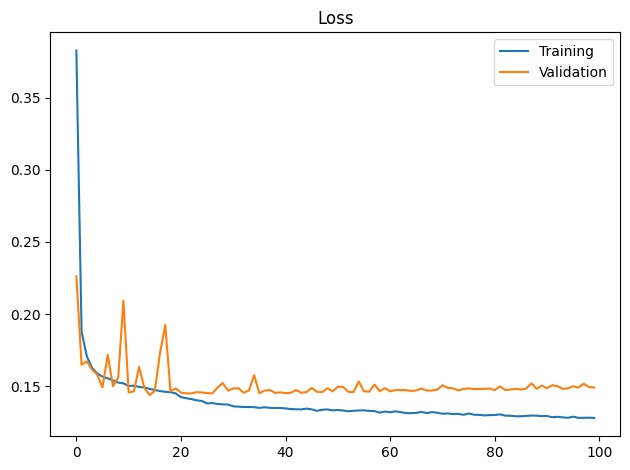

In [ ]:
import matplotlib.pyplot as plt
model_history = pd.DataFrame(history.history)
num_epochs = model_history.shape[0]
plt.plot(np.arange(0, num_epochs), model_history['loss'], label="Training")
plt.plot(np.arange(0, num_epochs), model_history['val_loss'], label="Validation")
plt.legend()
plt.title('Loss')
plt.tight_layout()
plt.show()

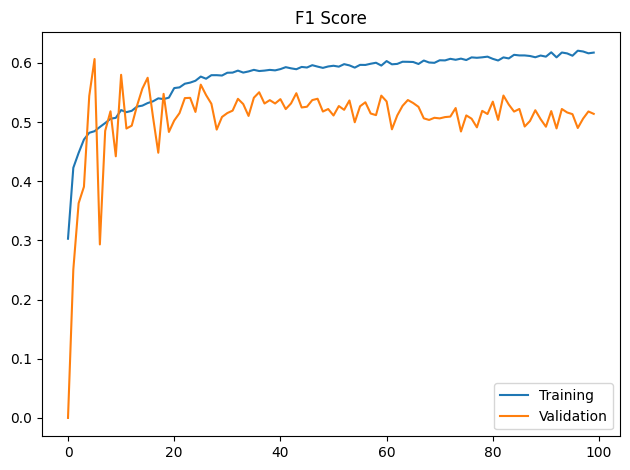

In [ ]:
plt.plot(np.arange(0, num_epochs), model_history['f1_score'], label="Training")
plt.plot(np.arange(0, num_epochs), model_history['val_f1_score'], label="Validation")
plt.legend()
plt.title('F1 Score')
plt.tight_layout()
plt.show()

In [ ]:
import yfinance as yf
ticker = yf.download("BTG", start='2010-01-01', end='2023-10-01', progress=True)
ticker.index = ticker.index.date
print("Calcolo indicatori ticker", flush=True)
ticker = fx.crea_indicatori(ticker)
ticker.dropna(axis=0, inplace=True)
print("Definizione features e target", flush=True)
idx, X, Y, scalers = fx.to_XY(ticker, fx.features_prezzo, fx.features_da_scalare_singolarmente, fx.features_meno_piu, fx.features_candele, fx.features_no_scala, fx.elenco_targets, fx.n_timesteps, 1, bilanciamento=0)
print(f'X.shape: {X.shape}')
print(f'Y.shape: {Y.shape}')
print(f'ticker.shape: {ticker.shape}')

[*********************100%%**********************]  1 of 1 completed
Calcolo indicatori ticker
Definizione features e target
X.shape: (3220, 120, 5)
Y.shape: (3220, 1)
ticker.shape: (3340, 49)


In [ ]:
pred = model.predict(X, batch_size=batch_size, verbose=1, use_multiprocessing=True)
pred_binary = (pred > soglia).astype(int)
loss, metrics = model.evaluate(X, Y, batch_size=batch_size, verbose=1, use_multiprocessing=True, return_dict=True)


4/4 [==============================] - 0s 12ms/step - loss: 0.0715 - f1_score: 0.3268


In [ ]:
pd.set_option('display.max_columns', None)
ris = pd.DataFrame(np.concatenate([Y, pred_binary], axis=1), columns=['Y', 'Prev'], index=idx)
ris = pd.merge(left=ris, right=ticker, how='left', left_index=True, right_index=True)
temp = ris[(ris['Prev'] == 1) & (ris['Y'] == 0)]
temp.tail(5)

,Y,Prev,Open,High,Low,Close,Adj Close,Volume,EMA_5,EMA_20,EMA_50,EMA_100,PSARaf,PSARr,PSAR,MACD,MACDh,MACDs,TSI,TSIs,SUPERT,SUPERTd,ADX,TRIX,TRIXs,AROONOSC,ATR,CMF,ROC_10,KVO,KVOs,VHF,OBV,Perc_Max_High_Futuro_20d,Perc_Drawdown_20d,EMA_20_5d,EMA_20_10d,EMA_20_15d,EMA_20_20d,EMA_50_5d,EMA_50_10d,EMA_50_15d,EMA_50_20d,Close_5d,Close_10d,Close_15d,Close_20d,DM_OSC,VTX_OSC,VI_OSC,Target
2022-10-05,0.0,1.0,3.31,3.45,3.29,3.45,3.292026,10552900,3.334487,3.236606,3.312106,3.488320,0.04,0,2.848128,-0.075500,0.029225,-0.104725,-0.347426,-8.040913,2.980013,1,12.196562,-0.186864,-0.181371,-50.0,0.153755,0.102858,9.523808,4.511343e+05,206060.318514,0.420118,-75241500.0,4.833840,13.897282,3.208434,3.114041,3.120271,3.099917,3.286835,3.229514,3.210391,3.185498,3.10,2.92,3.20,2.93,1.672317,0.107143,407.124542,False
2022-10-06,0.0,1.0,3.43,3.47,3.30,3.38,3.225231,11360900,3.349658,3.250263,3.314769,3.486175,0.04,0,2.873403,-0.064506,0.032175,-0.096681,1.503155,-6.677475,2.980013,1,11.819935,-0.163324,-0.187194,-50.0,0.154916,0.147375,8.333341,1.878982e+05,203465.724298,0.425150,-86602400.0,-2.332366,16.909625,3.193345,3.098418,3.122150,3.079925,3.277547,3.218553,3.207630,3.173910,3.05,2.95,3.14,2.89,2.233095,0.038961,405.095558,False
2022-11-08,0.0,1.0,3.19,3.39,3.14,3.36,3.206147,18788700,3.183884,3.121464,3.180933,3.339372,0.02,1,2.850000,-0.059469,0.021805,-0.081274,-0.073275,-5.602348,2.808944,1,10.949484,-0.147388,-0.173437,90.0,0.153702,0.133545,6.666660,6.920398e+05,119734.028497,0.290123,-84419300.0,14.420064,0.000000,3.260915,3.314233,3.374224,3.398038,3.233781,3.262982,3.300249,3.326065,3.45,3.48,3.48,3.35,6.588631,0.023649,425.461934,False
2022-11-09,0.0,1.0,3.34,3.39,3.24,3.28,3.129810,12816200,3.215923,3.136563,3.184818,3.338196,0.02,0,2.860800,-0.048255,0.026415,-0.074670,2.021181,-4.513272,2.859247,1,11.017839,-0.126095,-0.165762,95.0,0.153438,0.085091,2.499998,9.307971e+05,235600.181272,0.279762,-97235500.0,9.281443,2.095806,3.276066,3.336687,3.391917,3.394415,3.241084,3.274238,3.310435,3.327396,3.42,3.55,3.56,3.36,6.263358,0.093333,427.842885,False
2022-11-10,0.0,1.0,3.45,3.56,3.43,3.53,3.368362,13440900,3.320615,3.174033,3.198355,3.341994,0.04,0,2.871384,-0.024322,0.040279,-0.064601,6.772429,-2.901029,3.020035,1,11.537832,-0.093118,-0.155304,100.0,0.162478,0.184824,12.420377,1.159358e+06,367565.607587,0.340426,-83794600.0,5.797103,5.217393,3.283107,3.353193,3.408877,3.391138,3.245355,3.283483,3.320614,3.328674,3.35,3.51,3.57,3.36,11.078311,0.260726,435.464836,False


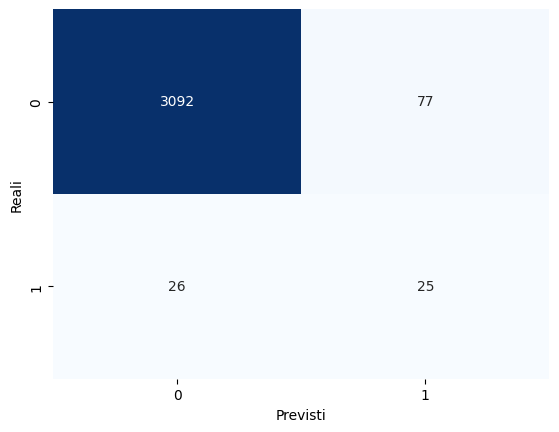

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
matrice = confusion_matrix(Y, pred_binary)

# Visualizza come heatmap
sns.heatmap(matrice, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Previsti')
plt.ylabel('Reali')
plt.show()

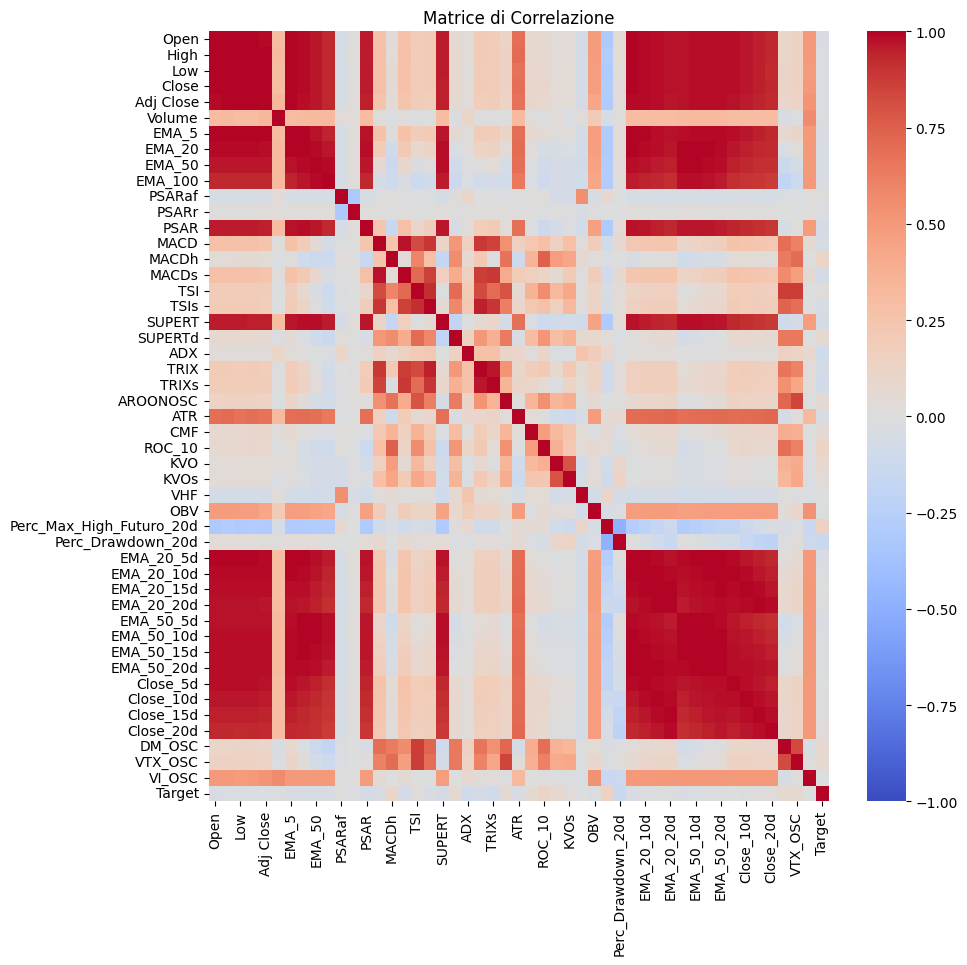

In [ ]:
correlation_matrix = ticker.corr()
plt.figure(figsize=(20,20)) 
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matrice di Correlazione")
plt.show()

In [ ]:
model.save('best_model.h5')